In [1]:
import torch
import numpy as np

from typing import Optional, Tuple

import ase
import ase.io
from ase import Atoms
import tqdm
import matscipy

import matplotlib.pyplot as plt
import matscipy.neighbours
import numpy as np
from torch.autograd.functional import jvp
import ase.spectrum.band_structure


In [2]:
def get_neighborhood(
    positions: np.ndarray,  # [num_positions, 3]
    cutoff: float,
    pbc: Optional[Tuple[bool, bool, bool]] = None,
    cell: Optional[np.ndarray] = None,  # [3, 3]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if pbc is None:
        pbc = (False, False, False)

    if cell is None or np.all(cell == 0.0):
        cell = np.identity(3, dtype=float)

    assert len(pbc) == 3 and all(isinstance(i, (bool, np.bool_)) for i in pbc)
    assert cell.shape == (3, 3)

    # Note (mario): I swapped senders and receivers here
    # j = senders, i = receivers instead of the other way around
    # such that the receivers are always in the central cell.
    # This is important to propagate message passing towards the center which can be useful in some cases.
    receivers, senders, senders_unit_shifts = matscipy.neighbours.neighbour_list(
        quantities="ijS",
        pbc=pbc,
        cell=cell,
        positions=positions,
        cutoff=cutoff,
    )

    # From the docs: With the shift vector S, the distances D between atoms can be computed from
    # D = positions[j]-positions[i]+S.dot(cell)
    # Note (mario): this is done in the function get_edge_relative_vectors
    return senders, receivers, senders_unit_shifts

# define our 3D cubic lattice and find out the nearest neighbors
r_max = 1.2
d = 1.0
L = 10.0
cubic_lat = Atoms('C',
             positions=[[0, 0, 0]],
             cell=[d, d, d],
             pbc=[1, 1, 1])

senders, receivers, senders_unit_shifts = get_neighborhood(
    positions=cubic_lat.positions,
    cutoff=r_max,
    pbc=cubic_lat.pbc,
    cell=cubic_lat.cell.array,
)

In [3]:
shift_vec = senders_unit_shifts @ cubic_lat.cell.array

cubic_pos = np.vstack((np.array([[0.0,0.0,0.0]]),shift_vec))
cubic_pos = torch.tensor(cubic_pos,requires_grad = True)

In [4]:
# manual input for the pairs in the cubic for now
cubic_spring_pairs = torch.tensor([[0,1],
                                  [0,2],
                                  [0,3],
                                  [0,4],
                                  [0,5],
                                  [0,6]])

# mass and spring phonon model
def cubic_spring_energy(cubic_pos):
    edge_vec = cubic_pos[cubic_spring_pairs[:,1]] - cubic_pos[cubic_spring_pairs[:,0]]
    edge_len = edge_vec.norm(dim=1)
    return torch.sum((edge_len-1.0)**2)
    
cubic_spring_energy(cubic_pos)

tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)

In [5]:
def calc_force(cubic_pos):
    cubic_energy = cubic_spring_energy(cubic_pos)
    
    cubic_forces = torch.autograd.grad(
        cubic_energy,
        cubic_pos,
        retain_graph = True,
        create_graph=True,
    )[0]
    return cubic_forces

cubic_forces = calc_force(cubic_pos)


In [6]:
cubic_pos_np = torch.detach(cubic_pos).numpy()
full_basis = np.eye(
    cubic_pos_np.size, dtype=cubic_pos_np.dtype
).reshape(-1, *cubic_pos_np.shape)

full_hessian = []
for basis in full_basis:
    basis = torch.tensor(basis)
    cubic_hessian = jvp(
        calc_force,
        cubic_pos,
        v=basis,
        create_graph=True,
    )
    full_hessian.append(cubic_hessian[1][None,:,:])

full_hessian = torch.vstack(full_hessian)
full_hessian = full_hessian.reshape(cubic_pos.shape + cubic_pos.shape)

full_hessian.shape


torch.Size([7, 3, 7, 3])

In [7]:
cell = ase.Atoms(cell=cubic_lat.cell, pbc=[True,True,True]).cell
rec_vecs_cubic = 2 * np.pi * cell.reciprocal().real
mp_band_path_cubic = cell.bandpath(npoints=300)
all_kpts_cubic = mp_band_path_cubic.kpts @ rec_vecs_cubic


In [8]:
def hessian_k(kpt,pos,H,num_atoms,idx0):
    Hk = torch.zeros((num_atoms,3,num_atoms,3),dtype=torch.complex64)
    num_sites = pos.shape[0]
    
    for idx1 in range(num_sites):
        idx0_1 = idx0[idx1]
        for idx2 in range(num_sites):
            idx0_2 = idx0[idx2]
            Hk[idx0_1,:,idx0_2,:] += H[idx1,:,idx2,:] * torch.exp(-1j*torch.dot(kpt,pos[idx1]-pos[idx2]))
    Hk = Hk.reshape((num_atoms*3,num_atoms*3))
    return Hk

In [9]:
def sqrt(x):
    return  np.sign(x) * np.sqrt(np.abs(x))

all_eigs_cubic = []
num_atoms = 1
cubic_idx0 = torch.zeros((7),dtype=torch.long)
for kpt in tqdm.tqdm(all_kpts_cubic):
    # print(kpt)
    #Hk = dynamical_matrix(kpt, cubic_graph, H_cubic, masses = np.array([1.0]))
    Hk = hessian_k(kpt=torch.tensor(kpt,dtype=torch.float64),
                   pos=cubic_pos,
                   H=full_hessian,
                   num_atoms=num_atoms,
                   idx0=cubic_idx0)
    all_eigs_cubic.append(np.sort(sqrt(np.linalg.eigh(Hk.detach().numpy())[0])))

all_eigs_cubic = np.stack(all_eigs_cubic)

bs_cubic = ase.spectrum.band_structure.BandStructure(mp_band_path_cubic, all_eigs_cubic[None])


100%|██████████████████████████████████████████████████████| 300/300 [00:00<00:00, 659.93it/s]


Text(0.5, 1.0, 'Simple cubic lattice')

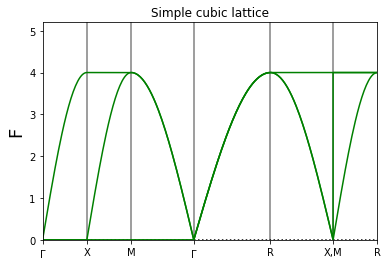

In [13]:
bs_cubic.plot(emin=1.1 * np.min(all_eigs_cubic), emax=1.3 * np.max(all_eigs_cubic))
plt.ylabel("F",size=18)
plt.title('Simple cubic lattice')